# Support Vector Machine

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits import mplot3d
import pandas as pd
import seaborn as sns
from scipy.stats import uniform, normaltest
from sklearn import svm, neighbors, tree
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve, GridSearchCV, validation_curve
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, CategoricalNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans,AgglomerativeClustering,SpectralClustering
from sklearn.preprocessing import normalize, PowerTransformer, OneHotEncoder, OrdinalEncoder, Normalizer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, roc_curve, roc_auc_score, plot_confusion_matrix,plot_roc_curve
from sklearn.metrics import rand_score,adjusted_mutual_info_score

## Importing Data and Pre-processing

In [2]:
# Import Data
data = pd.read_csv('data.txt',index_col=0)
pd.set_option('display.max_columns', 12)
data.head(7)

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5,Contains_Crack,Position_of_Crack
0,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
1,161.168,1.043284,1.038036,0.094323,1.031535,1.092445,...,0.069334,0.086817,0.460091,0.254838,Yes,Top Right
2,164.121,1.146271,1.026070,0.055705,1.013540,1.031031,...,0.391759,0.011229,0.163528,0.319310,Yes,Top Left
3,162.045,1.042523,1.045912,0.044661,1.056414,1.046251,...,0.053956,0.022008,0.054064,0.054362,Yes,Bottom Left
4,163.042,1.040145,1.030799,0.015596,1.043248,1.064751,...,0.053708,0.016016,0.057733,0.101230,Yes,Bottom Right
5,163.770,1.043534,1.043524,0.000001,1.043544,1.043534,...,0.053607,0.000155,0.053609,0.053611,No,No Crack
6,159.572,1.047045,1.027146,0.083370,1.042486,1.054308,...,0.146392,0.110386,0.068477,0.118288,Yes,Top Right


In [4]:
# Adding Noise
np.random.seed(1)
for col in data:
    if col != 'Contains_Crack' and col != 'Position_of_Crack':
        std_TR = np.std(data.loc[data['Position_of_Crack'] == 'Top Right', col])
        std_TL = np.std(data.loc[data['Position_of_Crack'] == 'Top Left', col])
        std_BL = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Left', col])
        std_BR = np.std(data.loc[data['Position_of_Crack'] == 'Bottom Right', col])
        std_avg = (std_TR+std_TL+std_BL+std_BR)/4
    
        noise = np.random.uniform(-std_avg,std_avg,len(data[col]))
        data[col] = data[col] + noise
data.shape

(100, 56)

In [5]:
# Remove the target from the dataset
data.dropna(axis=0, subset=['Contains_Crack','Position_of_Crack'], inplace=True)
y1 = data.Contains_Crack
y2 = data.Position_of_Crack
data.drop(['Contains_Crack','Position_of_Crack'], axis=1, inplace=True)
data

,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
0,163.516307,1.038170,1.068703,0.021232,1.062176,0.830729,...,838.715944,0.142866,0.098044,0.036677,0.128474,0.030246
1,161.841610,1.044121,1.041205,0.119850,1.043862,0.951773,...,822.922837,0.565163,0.135012,0.129534,0.459730,0.288985
2,162.592673,1.158212,1.049316,0.068532,0.994574,0.935274,...,825.845806,0.053755,0.275476,0.058117,0.141599,0.425193
3,161.440661,1.038107,1.053830,0.049393,1.064906,0.878473,...,838.426601,0.120835,0.173844,-0.024460,0.083506,0.037301
4,161.962008,1.052786,1.024647,-0.007485,1.041829,1.119997,...,835.374843,0.085093,-0.047885,0.068026,0.031878,0.102733
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,162.965998,1.056900,1.019373,0.023410,1.061058,0.888231,...,843.224625,-0.005461,-0.050806,0.051564,0.064393,-0.022629
96,160.879274,1.022117,1.119511,0.082316,1.057186,0.832265,...,827.146286,0.127383,0.116638,0.248995,0.304281,0.077025
97,162.440264,1.028118,1.011183,0.019398,1.055071,0.977400,...,828.464281,0.000394,0.245330,0.056035,0.243257,0.208921
98,163.178099,1.018555,1.058280,0.050581,1.157652,0.794373,...,835.827020,0.500143,0.284131,0.042238,0.096635,0.045737


In [6]:
# Encoding targets
for idx in range(len(y1)):
    if y1[idx] == 'Yes':
        y1[idx] = int(1)
    elif y1[idx] == 'No': 
        y1[idx] = int(0)
    
    if y2[idx] == 'No Crack':
        y2[idx] = int(0)
    elif y2[idx] == 'Top Right':
        y2[idx] = int(1)
    elif y2[idx] == 'Top Left':
        y2[idx] = int(2)
    elif y2[idx] == 'Bottom Left':
        y2[idx] = int(3)
    elif y2[idx] == 'Bottom Right':
        y2[idx] = int(4)
y1.to_numpy(dtype=int)

array([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1])

In [7]:
# Split the data into feature sets
X1 = data
X2 = data[['nf1','nf2','nf3','nf4','nf5','nf6','nf7','nf8','nf9']]
amp1 = data[['nf1_amp1','nf2_amp1','nf3_amp1','nf4_amp1','nf5_amp1','nf6_amp1','nf7_amp1','nf8_amp1','nf9_amp1']].max(axis=1)
amp2 = data[['nf1_amp2','nf2_amp2','nf3_amp2','nf4_amp2','nf5_amp2','nf6_amp2','nf7_amp2','nf8_amp2','nf9_amp2']].max(axis=1)
amp3 = data[['nf1_amp3','nf2_amp3','nf3_amp3','nf4_amp3','nf5_amp3','nf6_amp3','nf7_amp3','nf8_amp3','nf9_amp3']].max(axis=1)
amp4 = data[['nf1_amp4','nf2_amp4','nf3_amp4','nf4_amp4','nf5_amp4','nf6_amp4','nf7_amp4','nf8_amp4','nf9_amp4']].max(axis=1)
amp5 = data[['nf1_amp5','nf2_amp5','nf3_amp5','nf4_amp5','nf5_amp5','nf6_amp5','nf7_amp5','nf8_amp5','nf9_amp5']].max(axis=1)
X3 = pd.DataFrame({'amp1':amp1,'amp2':amp2,'amp3':amp3,'amp4':amp4,'amp5':amp5})

In [8]:
# Splitting into testing and training for the different feature sets
X_train11, X_test11, y_train11, y_test11 = train_test_split(X1, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train21, X_test21, y_train21, y_test21 = train_test_split(X2, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train31, X_test31, y_train31, y_test31 = train_test_split(X3, y1.to_numpy(dtype=int), test_size=0.2, random_state = 0)

X_train12, X_test12, y_train12, y_test12 = train_test_split(X1, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train22, X_test22, y_train22, y_test22 = train_test_split(X2, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)
X_train32, X_test32, y_train32, y_test32 = train_test_split(X3, y2.to_numpy(dtype=int), test_size=0.2, random_state = 0)

In [9]:
# Mean Center the data
for col in X_train11:
    X_test11.loc[:,col] = X_test11.loc[:,col] - X_train11.loc[:,col].mean()
    X_train11.loc[:,col] = X_train11.loc[:,col] - X_train11.loc[:,col].mean()
    
    X_test12.loc[:,col] = X_test12.loc[:,col] - X_train12.loc[:,col].mean()
    X_train12.loc[:,col] = X_train12.loc[:,col] - X_train12.loc[:,col].mean()

for col in X_train21:
    X_test21.loc[:,col] = X_test21.loc[:,col] - X_train21.loc[:,col].mean()
    X_train21.loc[:,col] = X_train21.loc[:,col] - X_train21.loc[:,col].mean()
    
    X_test22.loc[:,col] = X_test22.loc[:,col] - X_train22.loc[:,col].mean()
    X_train22.loc[:,col] = X_train22.loc[:,col] - X_train22.loc[:,col].mean()
    
for col in X_train31:
    X_test31.loc[:,col] = X_test31.loc[:,col] - X_train31.loc[:,col].mean()
    X_train31.loc[:,col] = X_train31[col] - X_train31[col].mean()
    
    X_test32.loc[:,col] = X_test32.loc[:,col] - X_train32.loc[:,col].mean()
    X_train32.loc[:,col] = X_train32.loc[:,col] - X_train32.loc[:,col].mean()

X_train11

C:\Users\James\anaconda3\lib\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


,nf1,nf1_amp1,nf1_amp2,nf1_amp3,nf1_amp4,nf1_amp5,...,nf9,nf9_amp1,nf9_amp2,nf9_amp3,nf9_amp4,nf9_amp5
43,3.581602,-0.048451,-0.043658,0.052843,0.100453,-0.158342,...,-0.181764,0.356719,0.337481,0.177689,-0.074283,0.050663
62,1.604523,0.025551,0.007492,0.004462,-0.022159,0.030694,...,-1.271669,-0.142383,-0.115478,0.050465,0.031750,0.175242
3,-0.952166,-0.004978,0.001227,0.013602,0.016607,-0.294224,...,4.279401,-0.045163,0.043198,-0.098740,-0.060349,-0.100357
71,-0.730195,0.010480,-0.007981,-0.061000,-0.010028,0.055629,...,-0.387632,-0.141004,-0.026556,0.075769,0.035946,0.057299
45,1.217865,-0.011695,-0.002813,-0.025489,0.011686,-0.381480,...,5.493934,-0.156968,-0.144323,-0.128259,-0.087670,-0.010572
...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,-1.513553,-0.020967,0.066908,0.046525,0.008887,-0.340432,...,-7.000913,-0.038615,-0.014008,0.174715,0.160426,-0.060633
67,-3.011306,-0.006248,-0.003369,0.057404,-0.000890,0.087405,...,7.184263,0.033165,-0.159252,0.001808,-0.146549,-0.198326
64,-0.468779,-0.010707,0.005931,0.009249,0.010759,0.015932,...,-0.832896,0.133012,0.014252,0.299752,-0.118206,0.112470
47,-0.152822,0.002789,-0.014487,-0.026338,0.009009,-0.223336,...,4.725110,-0.170896,-0.006564,-0.107392,0.075193,-0.076399


## No Scaling

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



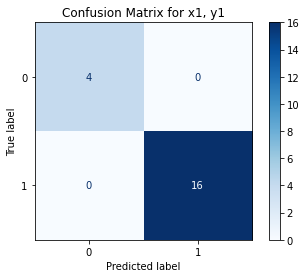

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



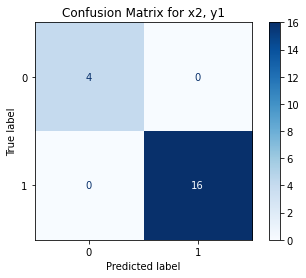

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.888888888888889 and AUC score of 0.5 



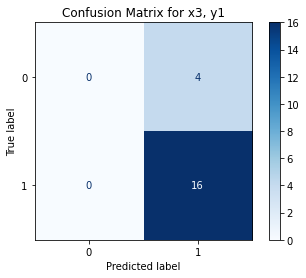

In [10]:
# Situation 1
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y1
x1y1 = svm.SVC(cache_size=1000)
x1y1_svm = GridSearchCV(x1y1, param_grid)
x1y1_svm.fit(X_train11, y_train11)

x1y1_predict = x1y1_svm.predict(X_test11)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_svm,X_test11,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1 = svm.SVC(cache_size=1000)
x2y1_svm = GridSearchCV(x2y1, param_grid)
x2y1_svm.fit(X_train21, y_train21)

x2y1_predict = x2y1_svm.predict(X_test21)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_svm,X_test21,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1 = svm.SVC(cache_size=1000)
x3y1_svm = GridSearchCV(x3y1, param_grid)
x3y1_svm.fit(X_train31, y_train31)

x3y1_predict = x3y1_svm.predict(X_test31)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_svm,X_test31,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [2 1 1 0 0 2 1 1 3 0 2 4 1 1 2 0 2 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.45 and f1 score of: 0.4444444444444445 and AUC score of 0.6818452380952381 



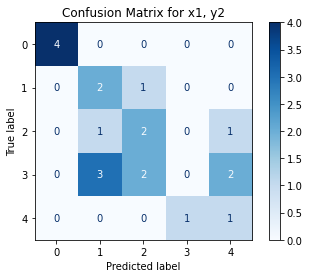

Predicted values using x2 and y2: [2 2 1 0 0 2 4 1 3 0 2 2 4 4 4 0 2 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.3244444444444444 and AUC score of 0.6694940476190475 



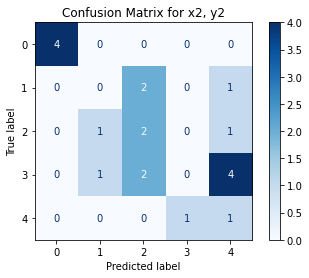

Predicted values using x3 and y2: [1 1 2 0 0 0 1 0 4 0 0 2 3 3 2 2 2 0 3 2]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.7 and f1 score of: 0.7224242424242424 and AUC score of 0.7827380952380952 



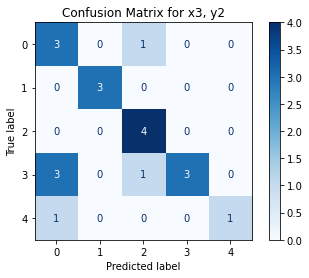

In [14]:
# Situation 2
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y2
x1y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x1y2_svm.fit(X_train12, y_train12)

x1y2_predict = x1y2_svm.predict(X_test12)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_svm.predict_proba(X_test12)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_svm,X_test12,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x2y2_svm.fit(X_train22, y_train22)

x2y2_predict = x2y2_svm.predict(X_test22)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_svm.predict_proba(X_test22)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_svm,X_test22,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x3y2_svm.fit(X_train32, y_train32)

x3y2_predict = x3y2_svm.predict(X_test32)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_svm.predict_proba(X_test32)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_svm,X_test32,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

In [11]:
C = np.linspace(0.1,10000,100)
gamma = np.linspace(0.0001,0.1,100)
U1,U2 = np.meshgrid(C,gamma)

accuracy1 = np.ones([100,100])
accuracy2 = np.ones([100,100])

accuracy3 = []
accuracy4 = []

for i in range(len(C)):
    for j in range(len(gamma)):
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test1_svm.fit(X_train12, y_train12)
        test1_predict = test1_svm.predict(X_test12)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy1[i,j] = test1_F1_score
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test2_svm.fit(X_train32, y_train32)
        test2_predict = test2_svm.predict(X_test32)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy2[i,j] = test2_F1_score
        
for Ci in C:
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test1_svm.fit(X_train12, y_train12)
        test1_predict = test1_svm.predict(X_test12)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy3.append(test1_F1_score)
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test2_svm.fit(X_train32, y_train32)
        test2_predict = test2_svm.predict(X_test32)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy4.append(test2_F1_score)

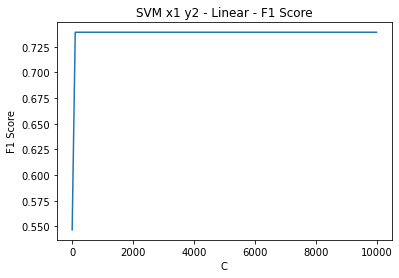

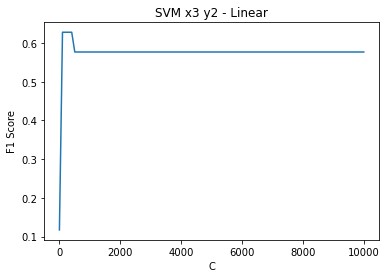

In [12]:
plt.figure()
plt.plot(C,accuracy3)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x1 y2 - Linear - F1 Score')
plt.show()

plt.figure()
plt.plot(C,accuracy4)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x3 y2 - Linear')
plt.show()

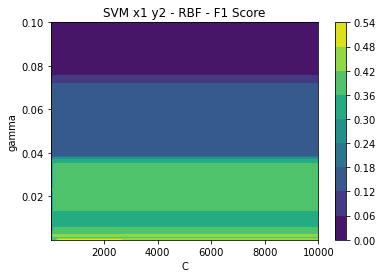

C = 6666.7 : gamma = 0.0001 : F1 Score = 0.7224242424242424


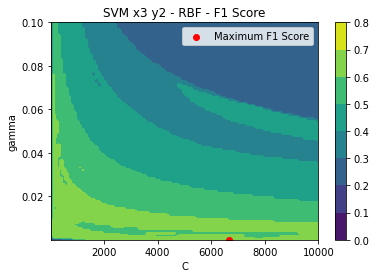

In [13]:
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x1 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy1)
plt.colorbar(cs)
plt.show()

maxi = np.amax(accuracy2)

gammai = []
Ci = []

for i in range(100):
    for j in range(100):
        if accuracy2[i,j] == maxi:
            Ci.append(U1[i,j])
            gammai.append(U2[i,j])
            print('C =',U1[i,j],': gamma =',U2[i,j],': F1 Score =',accuracy2[i,j])
            
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x3 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy2)
plt.scatter(Ci,gammai,color='red',marker='o',label='Maximum F1 Score')
plt.legend()
plt.colorbar(cs)
plt.show()

## Normalisation

In [15]:
# Normalize the data
normalizer = Normalizer('l2')
X_train11_norm = pd.DataFrame(normalizer.fit_transform(X_train11))
X_test11_norm = pd.DataFrame(normalizer.transform(X_test11))
  
normalizer = Normalizer('l2')
X_train12_norm = pd.DataFrame(normalizer.fit_transform(X_train12))
X_test12_norm = pd.DataFrame(normalizer.transform(X_test12))

normalizer = Normalizer('l2')
X_train21_norm = pd.DataFrame(normalizer.fit_transform(X_train21))
X_test21_norm = pd.DataFrame(normalizer.transform(X_test21))

normalizer = Normalizer('l2')
X_train22_norm = pd.DataFrame(normalizer.fit_transform(X_train22))
X_test22_norm = pd.DataFrame(normalizer.transform(X_test22))

normalizer = Normalizer('l2')
X_train31_norm = pd.DataFrame(normalizer.fit_transform(X_train31))
X_test31_norm = pd.DataFrame(normalizer.transform(X_test31))

normalizer = Normalizer('l2')
X_train32_norm = pd.DataFrame(normalizer.fit_transform(X_train32))
X_test32_norm = pd.DataFrame(normalizer.transform(X_test32))

X_train32_norm

,0,1,2,3,4
0,0.397813,-0.238586,-0.095298,0.771969,0.424032
1,0.513168,-0.005580,-0.062190,-0.272431,-0.811506
2,-0.361775,-0.090618,0.079766,-0.494664,-0.780930
3,0.582187,0.047607,-0.104903,0.084496,-0.800404
4,-0.603528,0.077316,0.087650,0.217709,-0.758088
...,...,...,...,...,...
75,0.231797,0.803299,0.091714,0.215936,-0.495925
76,0.388689,0.401395,0.165437,0.481770,-0.654471
77,-0.121543,-0.348609,-0.077263,-0.228691,0.897458
78,-0.040054,0.067348,-0.045395,0.686705,0.721273


Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



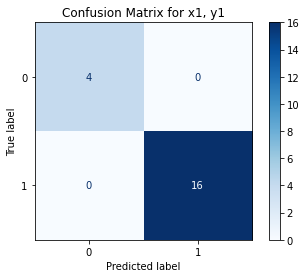

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



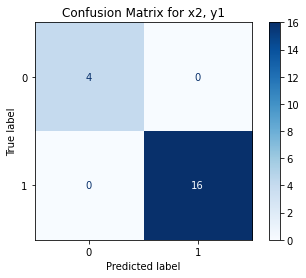

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.888888888888889 and AUC score of 0.5 



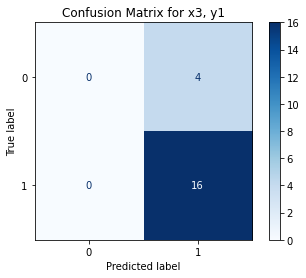

In [17]:
# Situation 1
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y1
x1y1 = svm.SVC(cache_size=1000)
x1y1_svm = GridSearchCV(x1y1, param_grid)
x1y1_svm.fit(X_train11_norm, y_train11)

x1y1_predict = x1y1_svm.predict(X_test11_norm)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_svm,X_test11_norm,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1 = svm.SVC(cache_size=1000)
x2y1_svm = GridSearchCV(x2y1, param_grid)
x2y1_svm.fit(X_train21_norm, y_train21)

x2y1_predict = x2y1_svm.predict(X_test21_norm)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_svm,X_test21_norm,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1 = svm.SVC(cache_size=1000)
x3y1_svm = GridSearchCV(x3y1, param_grid)
x3y1_svm.fit(X_train31_norm, y_train31)

x3y1_predict = x3y1_svm.predict(X_test31_norm)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_svm,X_test31_norm,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

Predicted values using x1 and y2: [2 3 2 0 0 2 1 2 3 0 2 2 1 4 2 0 2 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.5 and f1 score of: 0.48 and AUC score of 0.7437499999999999 



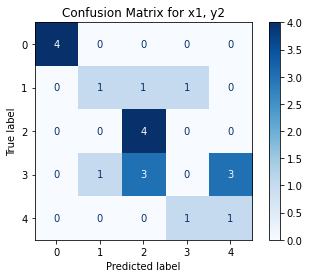

Predicted values using x2 and y2: [4 2 4 0 0 2 4 2 3 0 2 2 1 4 2 0 3 4 4 4]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.35 and f1 score of: 0.3244444444444444 and AUC score of 0.7595238095238095 



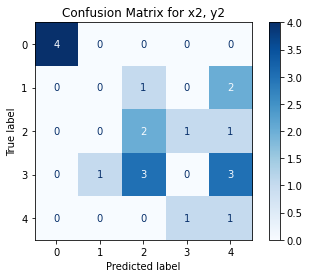

Predicted values using x3 and y2: [1 1 2 0 0 3 1 0 4 0 0 2 3 3 2 2 2 0 3 3]
Expected values: [1 1 2 0 0 3 1 3 4 0 3 2 3 3 2 0 2 4 3 3]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.7977777777777777 and AUC score of 0.7822916666666667 



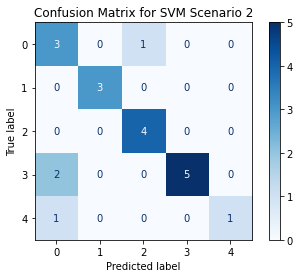

In [34]:
# Situation 2
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y2
x1y2_svm = svm.SVC(cache_size=1000, probability=True, C=3333.3999, gamma=0.00312727, kernel='rbf')
x1y2_svm.fit(X_train12_norm, y_train12)

x1y2_predict = x1y2_svm.predict(X_test12_norm)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_svm.predict_proba(X_test12_norm)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_svm,X_test12_norm,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_svm = svm.SVC(cache_size=1000, probability=True, C=3333.3999, gamma=0.00312727, kernel='rbf')
x2y2_svm.fit(X_train22_norm, y_train22)

x2y2_predict = x2y2_svm.predict(X_test22_norm)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_svm.predict_proba(X_test22_norm)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_svm,X_test22_norm,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_svm = svm.SVC(cache_size=1000, probability=True, C=3333.3999, gamma=0.00312727, kernel='rbf')
x3y2_svm.fit(X_train32_norm, y_train32)

x3y2_predict = x3y2_svm.predict(X_test32_norm)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_svm.predict_proba(X_test32_norm)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_svm,X_test32_norm,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for SVM Scenario 2")
plt.show()

In [18]:
C = np.linspace(0.1,10000,100)
gamma = np.linspace(0.0001,0.1,100)
U1,U2 = np.meshgrid(C,gamma)

accuracy1 = np.ones([100,100])
accuracy2 = np.ones([100,100])

accuracy3 = []
accuracy4 = []

for i in range(len(C)):
    for j in range(len(gamma)):
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test1_svm.fit(X_train12_norm, y_train12)
        test1_predict = test1_svm.predict(X_test12_norm)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy1[i,j] = test1_F1_score
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test2_svm.fit(X_train32_norm, y_train32)
        test2_predict = test2_svm.predict(X_test32_norm)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy2[i,j] = test2_F1_score
        
for Ci in C:
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test1_svm.fit(X_train12_norm, y_train12)
        test1_predict = test1_svm.predict(X_test12_norm)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy3.append(test1_F1_score)
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test2_svm.fit(X_train32_norm, y_train32)
        test2_predict = test2_svm.predict(X_test32_norm)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy4.append(test2_F1_score)

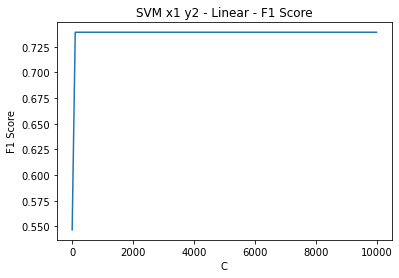

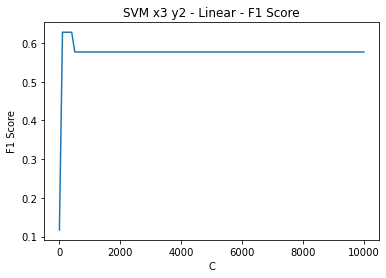

In [35]:
plt.figure()
plt.plot(C,accuracy3)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x1 y2 - Linear - F1 Score')
plt.show()

plt.figure()
plt.plot(C,accuracy4)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x3 y2 - Linear - F1 Score')
plt.show()

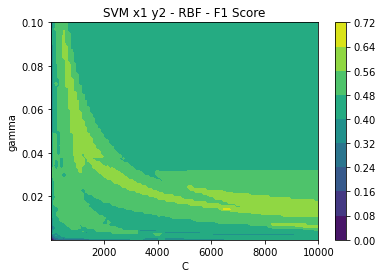

C = 2525.3272727272724 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 2626.3363636363633 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 2727.3454545454542 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 2828.354545454545 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 2929.363636363636 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3030.372727272727 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3131.381818181818 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3232.3909090909087 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3333.3999999999996 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3434.4090909090905 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3535.4181818181814 : gamma = 0.0011090909090909092 : F1 Score = 0.7977777777777777
C = 3636.4272727272723 : gamma = 0.001109090909

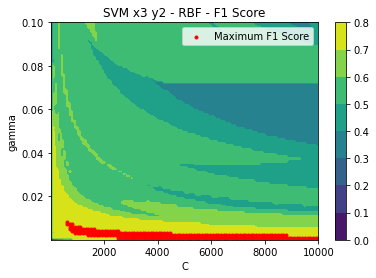

In [21]:
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x1 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy1)
plt.colorbar(cs)
plt.show()

maxi = np.amax(accuracy2)

gammai = []
Ci = []

for i in range(100):
    for j in range(100):
        if accuracy2[i,j] == maxi:
            Ci.append(U1[i,j])
            gammai.append(U2[i,j])
            print('C =',U1[i,j],': gamma =',U2[i,j],': F1 Score =',accuracy2[i,j])
            
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x3 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy2)
plt.scatter(Ci,gammai,color='red',marker='.',label='Maximum F1 Score')
plt.legend()
plt.colorbar(cs)
plt.show()

## Z Score Scaling

In [24]:
# Scaling
scaler = StandardScaler()
X_train11_z = scaler.fit_transform(X_train11)
X_test11_z = scaler.transform(X_test11)

scaler = StandardScaler()
X_train21_z = scaler.fit_transform(X_train21)
X_test21_z = scaler.transform(X_test21)

scaler = StandardScaler()
X_train31_z = scaler.fit_transform(X_train31)
X_test31_z = scaler.transform(X_test31)

scaler = StandardScaler()
X_train12_z = scaler.fit_transform(X_train12)
X_test12_z = scaler.transform(X_test12)

scaler = StandardScaler()
X_train22_z = scaler.fit_transform(X_train22)
X_test22_z = scaler.transform(X_test22)

scaler = StandardScaler()
X_train32_z = scaler.fit_transform(X_train32)
X_test32_z = scaler.transform(X_test32)

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



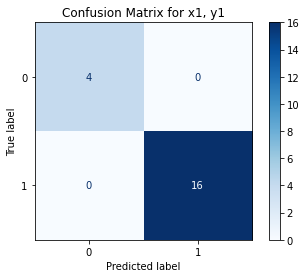

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



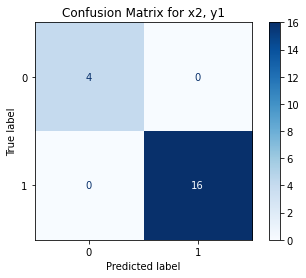

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.888888888888889 and AUC score of 0.5 



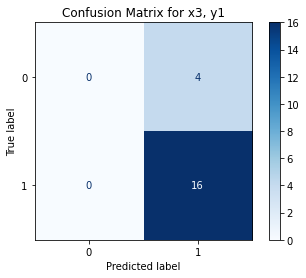

In [25]:
# Situation 1
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y1
x1y1 = svm.SVC(cache_size=1000)
x1y1_svm = GridSearchCV(x1y1, param_grid)
x1y1_svm.fit(X_train11_z, y_train11)

x1y1_predict = x1y1_svm.predict(X_test11_z)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_svm,X_test11_z,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1 = svm.SVC(cache_size=1000)
x2y1_svm = GridSearchCV(x2y1, param_grid)
x2y1_svm.fit(X_train21_z, y_train21)

x2y1_predict = x2y1_svm.predict(X_test21_z)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_svm,X_test21_z,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1 = svm.SVC(cache_size=1000)
x3y1_svm = GridSearchCV(x3y1, param_grid)
x3y1_svm.fit(X_train31_z, y_train31)

x3y1_predict = x3y1_svm.predict(X_test31_z)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_svm,X_test31_z,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

In [36]:
print(x1y1_svm.best_params_)

{'C': 0.1, 'kernel': 'linear'}


In [ ]:
# Situation 2
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y2
x1y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x1y2_svm.fit(X_train12_z, y_train12)

x1y2_predict = x1y2_svm.predict(X_test12_z)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_svm.predict_proba(X_test12_z)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_svm,X_test12_z,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x2y2_svm.fit(X_train22_z, y_train22)

x2y2_predict = x2y2_svm.predict(X_test22_z)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_svm.predict_proba(X_test22_z)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_svm,X_test22_z,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x3y2_svm.fit(X_train32_z, y_train32)

x3y2_predict = x3y2_svm.predict(X_test32_z)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_svm.predict_proba(X_test32_z)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_svm,X_test32_z,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

In [26]:
C = np.linspace(0.1,10000,100)
gamma = np.linspace(0.0001,0.1,100)
U1,U2 = np.meshgrid(C,gamma)

accuracy1 = np.ones([100,100])
accuracy2 = np.ones([100,100])

accuracy3 = []
accuracy4 = []

for i in range(len(C)):
    for j in range(len(gamma)):
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test1_svm.fit(X_train12_z, y_train12)
        test1_predict = test1_svm.predict(X_test12_z)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy1[i,j] = test1_F1_score
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test2_svm.fit(X_train32_z, y_train32)
        test2_predict = test2_svm.predict(X_test32_z)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy2[i,j] = test2_F1_score
        
for Ci in C:
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test1_svm.fit(X_train12_z, y_train12)
        test1_predict = test1_svm.predict(X_test12_z)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy3.append(test1_F1_score)
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test2_svm.fit(X_train32_z, y_train32)
        test2_predict = test2_svm.predict(X_test32_z)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy4.append(test2_F1_score)

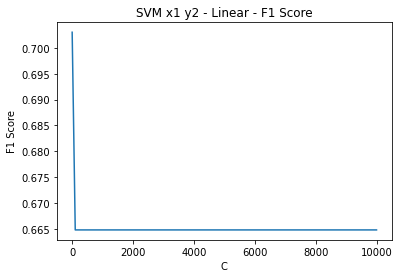

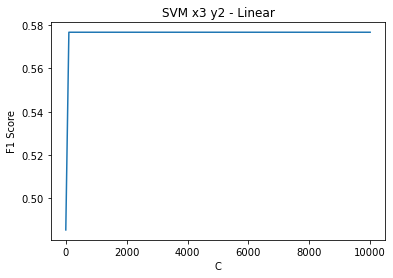

In [27]:
plt.figure()
plt.plot(C,accuracy3)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x1 y2 - Linear - F1 Score')
plt.show()

plt.figure()
plt.plot(C,accuracy4)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x3 y2 - Linear')
plt.show()

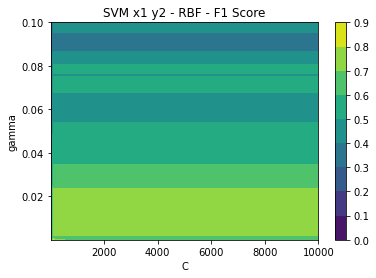

C = 707.1636363636363 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 808.1727272727272 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 909.1818181818181 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 1010.190909090909 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 1111.1999999999998 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 3737.4363636363632 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 3838.445454545454 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 3939.454545454545 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 4040.463636363636 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 4141.472727272727 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 4242.481818181818 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 4343.49090909091 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 4444.5 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 4545.50909090909 : gamma = 0.0001 : F1 Score = 0.6822222222222222
C = 101.109090909

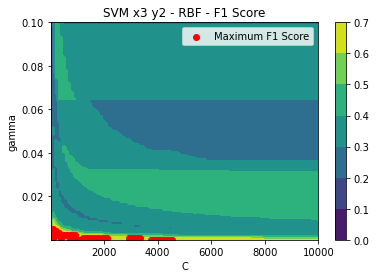

In [28]:
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x1 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy1)
plt.colorbar(cs)
plt.show()

maxi = np.amax(accuracy2)

gammai = []
Ci = []

for i in range(100):
    for j in range(100):
        if accuracy2[i,j] == maxi:
            Ci.append(U1[i,j])
            gammai.append(U2[i,j])
            print('C =',U1[i,j],': gamma =',U2[i,j],': F1 Score =',accuracy2[i,j])
            
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x3 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy2)
plt.scatter(Ci,gammai,color='red',marker='o',label='Maximum F1 Score')
plt.legend()
plt.colorbar(cs)
plt.show()

## PCS

In [29]:
# PCA
pca = PCA()
X_train11_PCS = pca.fit_transform(X_train11)
X_test11_PCS = pca.transform(X_test11)

pca = PCA()
X_train21_PCS = pca.fit_transform(X_train21)
X_test21_PCS = pca.transform(X_test21)

pca = PCA()
X_train31_PCS = pca.fit_transform(X_train31)
X_test31_PCS = pca.transform(X_test31)

pca = PCA()
X_train12_PCS = pca.fit_transform(X_train12)
X_test12_PCS = pca.transform(X_test12)

pca = PCA()
X_train22_PCS = pca.fit_transform(X_train22)
X_test22_PCS = pca.transform(X_test22)

pca = PCA()
X_train32_PCS = pca.fit_transform(X_train32)
X_test32_PCS =pca.transform(X_test32)

X_train11_PCS

array([[ 8.37659537e+00, -1.16080732e+01,  7.95487810e+00, ...,
        -1.34124936e-03, -5.65870716e-03, -7.24118352e-03],
       [ 4.87317662e+01, -9.99852623e+00, -5.34152127e+00, ...,
        -7.09420798e-04, -1.15699969e-04,  8.88687730e-03],
       [-1.57985831e+01,  2.50768193e+00,  2.78375561e-02, ...,
         1.16349860e-02,  1.73482187e-02, -6.76086863e-03],
       ...,
       [ 5.52037369e+01, -9.04275557e+00, -4.27233908e+00, ...,
        -3.99463833e-03,  4.18074437e-03, -1.65960319e-03],
       [-2.32143736e+01, -8.27094459e+00, -3.85431951e+00, ...,
        -6.20281396e-03, -1.76908111e-03,  8.01055891e-03],
       [ 9.05585377e+00,  8.16018500e+00,  1.92691506e-01, ...,
         1.01637411e-02, -1.36464649e-02,  4.23947310e-03]])

Predicted values using x1 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



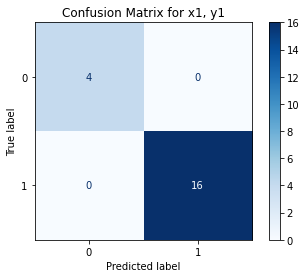

Predicted values using x2 and y1: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 1.0 and f1 score of: 1.0 and AUC score of 1.0 



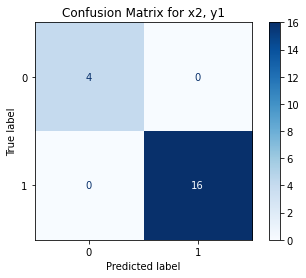

Predicted values using x3 and y1: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Expected values: [1 1 1 0 0 1 1 1 1 0 1 1 1 1 1 0 1 1 1 1]
Resulting in an accuracy score of: 0.8 and f1 score of: 0.888888888888889 and AUC score of 0.5 



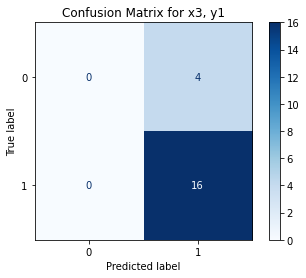

In [30]:
# Situation 1
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y1
x1y1 = svm.SVC(cache_size=1000)
x1y1_svm = GridSearchCV(x1y1, param_grid)
x1y1_svm.fit(X_train11_PCS, y_train11)

x1y1_predict = x1y1_svm.predict(X_test11_PCS)
x1y1_accuracy_score = accuracy_score(y_test11,x1y1_predict)
x1y1_f1_score = f1_score(y_test11,x1y1_predict)
x1y1_AUC_score = roc_auc_score(y_test11,x1y1_predict)

print("Predicted values using x1 and y1:",x1y1_predict)
print("Expected values:",y_test11)
print("Resulting in an accuracy score of:",x1y1_accuracy_score,"and f1 score of:",x1y1_f1_score,"and AUC score of",x1y1_AUC_score,"\n")
plot_confusion_matrix(x1y1_svm,X_test11_PCS,y_test11,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y1")
plt.show()

# x2 y1
x2y1 = svm.SVC(cache_size=1000)
x2y1_svm = GridSearchCV(x2y1, param_grid)
x2y1_svm.fit(X_train21_PCS, y_train21)

x2y1_predict = x2y1_svm.predict(X_test21_PCS)
x2y1_accuracy_score = accuracy_score(y_test21,x2y1_predict)
x2y1_f1_score = f1_score(y_test21,x2y1_predict) 
x2y1_AUC_score = roc_auc_score(y_test21,x2y1_predict)
    
print("Predicted values using x2 and y1:",x2y1_predict)
print("Expected values:",y_test21)
print("Resulting in an accuracy score of:",x2y1_accuracy_score,"and f1 score of:",x2y1_f1_score,"and AUC score of",x2y1_AUC_score,"\n")
plot_confusion_matrix(x2y1_svm,X_test21_PCS,y_test21,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y1")
plt.show()

# x3 y1
x3y1 = svm.SVC(cache_size=1000)
x3y1_svm = GridSearchCV(x3y1, param_grid)
x3y1_svm.fit(X_train31_PCS, y_train31)

x3y1_predict = x3y1_svm.predict(X_test31_PCS)
x3y1_accuracy_score = accuracy_score(y_test31,x3y1_predict)
x3y1_f1_score = f1_score(y_test31,x3y1_predict)
x3y1_AUC_score = roc_auc_score(y_test31,x3y1_predict)

print("Predicted values using x3 and y1:",x3y1_predict)
print("Expected values:",y_test31)
print("Resulting in an accuracy score of:",x3y1_accuracy_score,"and f1 score of:",x3y1_f1_score,"and AUC score of",x3y1_AUC_score,"\n")
plot_confusion_matrix(x3y1_svm,X_test31_PCS,y_test31,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y1")
plt.show()

In [ ]:
# Situation 2
param_grid = [
  {'C': [0.1, 1, 10, 100, 1000], 'kernel': ['linear']},
  {'C': [0.1, 1, 10, 100, 1000], 'gamma': [0.01, 0.001, 0.0001], 'kernel': ['rbf']},
  {'C': [0.1, 1, 10, 100, 1000], 'degree': [2,3,4], 'kernel': ['poly']},
 ]

# x1 y2
x1y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x1y2_svm.fit(X_train12_PCS, y_train12)

x1y2_predict = x1y2_svm.predict(X_test12_PCS)
x1y2_accuracy_score = accuracy_score(y_test12,x1y2_predict)
x1y2_f1_score = f1_score(y_test12,x1y2_predict,average='macro')
x1y2_y_prob = x1y2_svm.predict_proba(X_test12_PCS)
x1y2_AUC_score = roc_auc_score(y_test12,x1y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x1 and y2:",x1y2_predict)
print("Expected values:",y_test12)
print("Resulting in an accuracy score of:",x1y2_accuracy_score,"and f1 score of:",x1y2_f1_score,"and AUC score of",x1y2_AUC_score,"\n")
plot_confusion_matrix(x1y2_svm,X_test12_PCS,y_test12,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x1, y2")
plt.show()

# x2 y2
x2y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x2y2_svm.fit(X_train22_PCS, y_train22)

x2y2_predict = x2y2_svm.predict(X_test22_PCS)
x2y2_accuracy_score = accuracy_score(y_test22,x2y2_predict)
x2y2_f1_score = f1_score(y_test22,x2y2_predict,average='macro')
x2y2_y_prob = x2y2_svm.predict_proba(X_test22_PCS)
x2y2_AUC_score = roc_auc_score(y_test22,x2y2_y_prob,multi_class="ovo",average='macro')
    
print("Predicted values using x2 and y2:",x2y2_predict)
print("Expected values:",y_test22)
print("Resulting in an accuracy score of:",x2y2_accuracy_score,"and f1 score of:",x2y2_f1_score,"and AUC score of",x2y2_AUC_score,"\n")
plot_confusion_matrix(x2y2_svm,X_test22_PCS,y_test22,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x2, y2")
plt.show()

# x3 y2
x3y2_svm = svm.SVC(cache_size=1000, probability=True, C=6666.7, gamma=0.0001, kernel='rbf')
x3y2_svm.fit(X_train32_PCS, y_train32)

x3y2_predict = x3y2_svm.predict(X_test32_PCS)
x3y2_accuracy_score = accuracy_score(y_test32,x3y2_predict)
x3y2_f1_score = f1_score(y_test32,x3y2_predict,average='macro')
x3y2_y_prob = x3y2_svm.predict_proba(X_test32_PCS)
x3y2_AUC_score = roc_auc_score(y_test32,x3y2_y_prob,multi_class="ovo",average='macro')

print("Predicted values using x3 and y2:",x3y2_predict)
print("Expected values:",y_test32)
print("Resulting in an accuracy score of:",x3y2_accuracy_score,"and f1 score of:",x3y2_f1_score,"and AUC score of",x3y2_AUC_score,"\n")
plot_confusion_matrix(x3y2_svm,X_test32_PCS,y_test32,cmap=plt.cm.Blues)
plt.title("Confusion Matrix for x3, y2")
plt.show()

In [31]:
C = np.linspace(0.1,10000,100)
gamma = np.linspace(0.0001,0.1,100)
U1,U2 = np.meshgrid(C,gamma)

accuracy1 = np.ones([100,100])
accuracy2 = np.ones([100,100])

accuracy3 = []
accuracy4 = []

for i in range(len(C)):
    for j in range(len(gamma)):
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test1_svm.fit(X_train12_PCS, y_train12)
        test1_predict = test1_svm.predict(X_test12_PCS)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy1[i,j] = test1_F1_score
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = U1[i,j], gamma = U2[i,j], kernel = "rbf")
        test2_svm.fit(X_train32_PCS, y_train32)
        test2_predict = test2_svm.predict(X_test32_PCS)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy2[i,j] = test2_F1_score
        
for Ci in C:
        test1_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test1_svm.fit(X_train12_PCS, y_train12)
        test1_predict = test1_svm.predict(X_test12_PCS)
        test1_F1_score = f1_score(y_test12,test1_predict,average='macro')
        accuracy3.append(test1_F1_score)
        
        test2_svm = svm.SVC(cache_size=1000, probability=True, C = Ci, kernel = "linear")
        test2_svm.fit(X_train32_PCS, y_train32)
        test2_predict = test2_svm.predict(X_test32_PCS)
        test2_F1_score = f1_score(y_test32,test2_predict,average='macro')
        accuracy4.append(test2_F1_score)

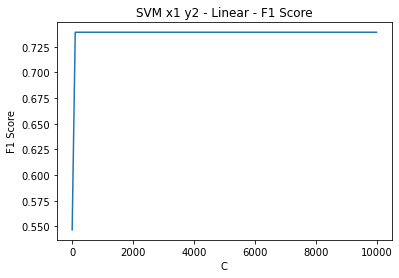

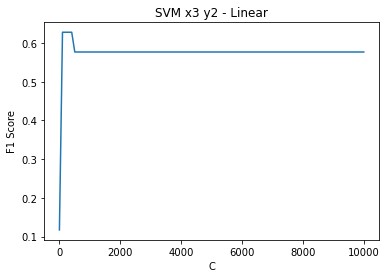

In [32]:
plt.figure()
plt.plot(C,accuracy3)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x1 y2 - Linear - F1 Score')
plt.show()

plt.figure()
plt.plot(C,accuracy4)
plt.xlabel("C")
plt.ylabel("F1 Score")
plt.title('SVM x3 y2 - Linear')
plt.show()

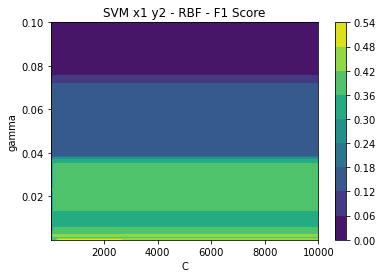

C = 6666.7 : gamma = 0.0001 : F1 Score = 0.7224242424242424


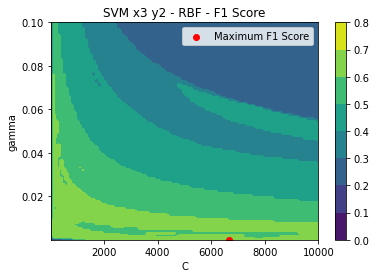

In [33]:
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x1 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy1)
plt.colorbar(cs)
plt.show()

maxi = np.amax(accuracy2)

gammai = []
Ci = []

for i in range(100):
    for j in range(100):
        if accuracy2[i,j] == maxi:
            Ci.append(U1[i,j])
            gammai.append(U2[i,j])
            print('C =',U1[i,j],': gamma =',U2[i,j],': F1 Score =',accuracy2[i,j])
            
plt.figure()
plt.xlabel("C")
plt.ylabel("gamma")
plt.title('SVM x3 y2 - RBF - F1 Score')
cs = plt.contourf(U1,U2,accuracy2)
plt.scatter(Ci,gammai,color='red',marker='o',label='Maximum F1 Score')
plt.legend()
plt.colorbar(cs)
plt.show()